# dividends vs no-dividends

compare SPY with and without dividends

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = 'SPY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

Timeseries

In [4]:
# fetch timeseries, select, finalize
ts = pf.fetch_timeseries(symbol)
ts = pf.select_tradeperiod(ts, start, end, use_adj=True)
ts, start = pf.finalize_timeseries(ts, start)

# create tradelog and daily balance objects
tlog = pf.TradeLog(symbol)
dbal = pf.DailyBal()

In [5]:
ts

,high,low,open,close,volume,adj_close
date,,,,,,
1993-01-29,26.20,26.07,26.20,26.18,1003200.00,26.18
1993-02-01,26.37,26.20,26.20,26.37,480500.00,26.37
1993-02-02,26.44,26.30,26.35,26.43,201300.00,26.43
1993-02-03,26.72,26.44,26.46,26.71,529400.00,26.71
1993-02-04,26.87,26.50,26.80,26.82,531500.00,26.82
...,...,...,...,...,...,...
2020-07-09,317.10,310.68,316.84,314.38,83354200.00,314.38
2020-07-10,317.88,312.76,314.31,317.59,57550400.00,317.59
2020-07-13,322.71,314.13,320.13,314.84,102997500.00,314.84


Algorithm

In [6]:
pf.TradeLog.cash = capital

# loop through timeseries
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # buy
    if tlog.shares == 0:
        tlog.buy(date, row.close)
    # sell
    elif end_flag:
        tlog.sell(date, row.close)

    # record daily balance
    dbal.append(date, row.high, row.low, row.close)

Retrieve logs and get stats

In [7]:
tlog = tlog.get_log()
dbal = dbal.get_log(tlog)
stats = pf.stats(ts, tlog, dbal, capital)

Benchmark: Run, retrieve logs, generate stats

In [8]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj=False)
benchmark.run()
benchmark.tlog, benchmark.dbal = benchmark.get_logs()
benchmark.stats = benchmark.get_stats()

1993-01-29 00:00:00 BUY  227 SPY @ 43.94
2020-07-15 00:00:00 SELL 227 SPY @ 321.85


Plot Equity Curves: Strategy vs Benchmark

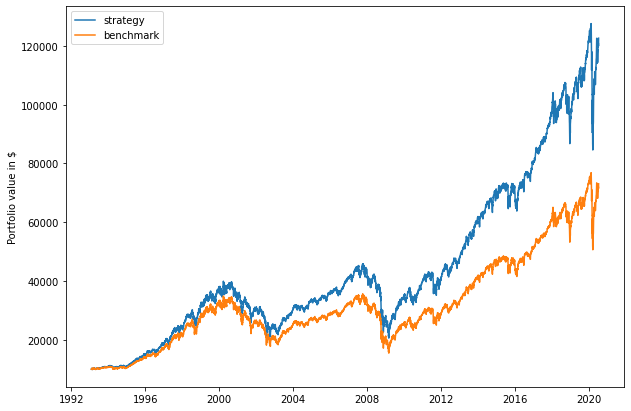

In [9]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Dividends (strategy) vs No-Dividends (benchmark)

In [10]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$122,648.73","$73,086.14"
total_net_profit,"$112,648.73","$63,086.14"
gross_profit,"$112,648.73","$63,086.14"
gross_loss,$0.00,$0.00


,strategy,benchmark
annual_return_rate,9.56,7.51
max_closed_out_drawdown,-55.16,-56.43
drawdown_annualized_return,-5.77,-7.51
drawdown_recovery,-1.42,-1.42
best_month,23.59,23.06
worst_month,-30.98,-31.38
sharpe_ratio,0.58,0.48
sortino_ratio,0.73,0.61
monthly_std,4.49,4.49
avg_month,0.82,0.67


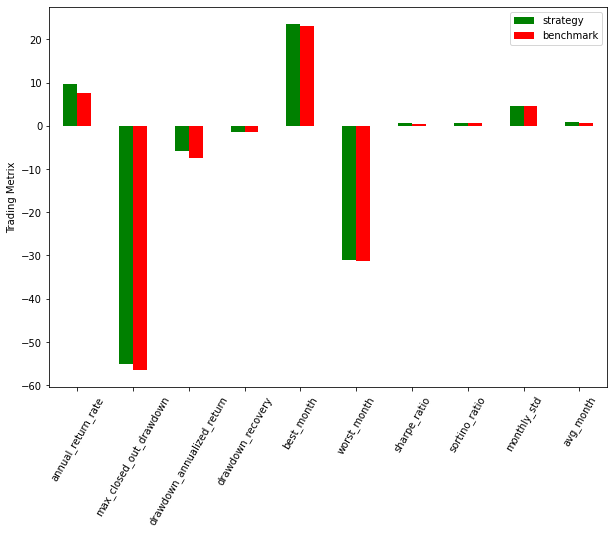

In [11]:
extras = ('avg_month',)

df = pf.plot_bar_graph(stats, benchmark.stats, extras=extras)
df